<p>In this notebook, we'll see how to fine-tune a NLLB-200 machine translation model for a new language.</p>
<p><a href="https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865">https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865</a></p>

# 0. Preliminaries

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [1]:
CUDA_CORE=3
MODEL_USED="models/nllb_quechua_esp_v4_1_3B"
# MODEL_USED="facebook/nllb-200-1.3B"
# MODEL_USED="facebook/nllb-200-3.3B"
MODEL_SAVE_PATH="models/nllb_inga_esp_sin_dict_1_3B"
LANGUAGE_ORIGIN_LABEL="spa_Latn"
LANGUAGE_TARGET_LABEL="ing_Latn"
LANGUAGE_SIMILAR_LABEL="quechua_Latn" # Quechua Transferr Learning
LANGUAGE_FILE="data/constitucion_ing_completo.csv"
LANGUAGE_FILE_ORIGIN_LABEL="esp"
LANGUAGE_FILE_TARGET_LABEL="ing"
NORMALIZER_LANGUAGE="es"
!mkdir -p {MODEL_SAVE_PATH}

In [2]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [3]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

In [4]:
!pip install ipywidgets

In [5]:
!pip install scikit-learn
import pandas as pd
from sklearn.model_selection import train_test_split

<h1 id="1.-Exploring-the-data">1. Exploring the data</h1>
<p>&nbsp;</p>

In [6]:
trans_df = pd.read_csv(LANGUAGE_FILE)
print(trans_df.shape)
print(trans_df.columns)

(212, 3)
Index(['esp', 'ing', 'parte'], dtype='object')


In [7]:
df_train, df_devtest = train_test_split(trans_df, test_size=0.2, random_state=42)
df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=42)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, 127 to 102
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   esp     169 non-null    object
 1   ing     169 non-null    object
 2   parte   169 non-null    object
dtypes: object(3)
memory usage: 5.3+ KB


In [9]:
df_train.head()

,esp,ing,parte
127,el estado garantiza las libertades de enseñanz...,nukanchipa atun llagta tukuikunatami iuka kuan...,articulos
108,el pueblo la ejerce en forma directa o por med...,chi suma iuaikuna nukanchikikin u atun taitaku...,articulos
69,en más de una ocasión tuvieron que volver a em...,kai achka lachag pangata nukanchipa simima ial...,coordinador
84,estas lenguas están entre las más habladas de ...,sugkunaka ñi nukanchi kikimpa rimaillatapas ma...,coordinador
97,artículos relativos a los derechos de las pers...,nukanchi ima mañangapa ministiska,titulos_constitucion


In [10]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 30 to 190
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   esp     21 non-null     object
 1   ing     21 non-null     object
 2   parte   21 non-null     object
dtypes: object(3)
memory usage: 672.0+ bytes


In [11]:
df_dev.head()

,esp,ing,parte
30,alfonso palma y al sr,achka iachag pangata nukanchipa simipi ialichi...,carta_traductor
177,"tomar parte en elecciones, plebiscitos, refere...",kline xan kimsa,articulos
163,las lenguas y dialectos de los grupos étnicos ...,nukanchipa sug rigcha kaugsai runakunapa rimai...,articulos
209,los distritos y los municipios percibirán como...,wawa llagtata katiraiagkuna mas achka kulkinmi...,articulos
189,la ley establecerá las formas de coordinación ...,"maikan nukanchi pandarispa kaugsanakugpika, nu...",articulos


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 96 to 25
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   esp     22 non-null     object
 1   ing     22 non-null     object
 2   parte   22 non-null     object
dtypes: object(3)
memory usage: 704.0+ bytes


In [13]:
df_test.head()

,esp,ing,parte
96,artículos relativos a los principios fundament...,kulumbiamanda achka iachag pangakuna iapa mini...,titulos_constitucion
150,algunos de los derechos son considerados funda...,"pusag chunga sugta, pusag chunga kanchis, pusa...",articulos
143,en los establecimientos del estado ninguna per...,achka iachag pangapa wawami maki kuangapa kank...,articulos
181,los ciudadanos colombianos que se encuentren o...,"iurakuna i nukanchipa runakunapas, sug llagtap...",articulos
73,este trabajo y una constante discusión sobre l...,"chikunata rigsigkuna sutikankunami: mamos, pay...",coordinador


# 2. How well does the data fit into a NLLB tokenizer?

In [14]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [16]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [17]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
print(tokenizer.convert_ids_to_tokens([262576, 262577, 262578])) # ['zul_Latn', 'quechua_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'quechua_Latn', '<mask>'])) # [256202, 256203, 256204]

['zul_Latn', '<mask>', 'quechua_Latn']
[262576, 262578, 262577]


In [19]:
fix_tokenizer(tokenizer, new_lang="quechua_Latn")

In [20]:
print(tokenizer.convert_ids_to_tokens([262576, 262577, 262578])) # ['zul_Latn', 'quechua_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'quechua_Latn', '<mask>'])) # [256202, 256203, 256204]

['zul_Latn', 'quechua_Latn', '<mask>']
[262576, 262577, 262578]


In [21]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [22]:
smpl = df_train.sample(10000, random_state=42, replace=True)
smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_toks'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(tokenizer.tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_toks'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(tokenizer.tokenize)

smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_words'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(word_tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_words'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(word_tokenize)

In [23]:
smpl.sample(5)[[LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_toks']]

,esp,esp_words,esp_toks,ing,ing_words,ing_toks
130,durante el embarazo y después del parto gozará...,"[durante, el, embarazo, y, después, del, parto...","[▁durante, ▁el, ▁embara, zo, ▁y, ▁después, ▁de...",wawawa ungug kaura i ña wamra iukaskauramanda ...,"[wawawa, ungug, kaura, i, ña, wamra, iukaskaur...","[▁wawa, wa, ▁ung, ug, ▁ka, ura, ▁i, ▁ña, ▁wam,..."
63,"la práctica de sus textos mitológicos, de sus ...","[la, práctica, de, sus, textos, mitológicos, ,...","[▁la, ▁práctica, ▁de, ▁sus, ▁textos, ▁mit, oló...","ña chi rimaikunata kaipi iachaikunakuska, chun...","[ña, chi, rimaikunata, kaipi, iachaikunakuska,...","[▁ña, ▁chi, ▁rima, ikun, ata, ▁kai, pi, ▁i, ac..."
46,la constitución es una ley mayor que guía las ...,"[la, constitución, es, una, ley, mayor, que, g...","[▁la, ▁constitu, ción, ▁es, ▁una, ▁ley, ▁mayor...","nispami tukui kai atun llagtapi kaugsagkuna, p...","[nispami, tukui, kai, atun, llagtapi, kaugsagk...","[▁nis, pami, ▁tuk, ui, ▁kai, ▁atun, ▁l, lag, t..."
103,artículos relativos a los planes de desarrollo,"[artículos, relativos, a, los, planes, de, des...","[▁artículos, ▁relativos, ▁a, ▁los, ▁planes, ▁d...",suma iuiarispa mirachii,"[suma, iuiarispa, mirachii]","[▁suma, ▁i, ui, aris, pa, ▁mira, chii]"
70,cada dos meses se reunían con nosotros en bogo...,"[cada, dos, meses, se, reunían, con, nosotros,...","[▁cada, ▁dos, ▁meses, ▁se, ▁reun, ían, ▁con, ▁...","suraka chaiami sug rigcha, sug rigcha kinguchi...","[suraka, chaiami, sug, rigcha, ,, sug, rigcha,...","[▁sur, aka, ▁chai, ami, ▁sug, ▁rig, cha, ,, ▁s..."


In [24]:
stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()
stats

/tmp/ipykernel_281235/105503015.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()


,esp_toks,ing_toks,esp_words,ing_words
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,33.531900,37.988200,25.641300,17.472700
std,25.285429,27.055075,18.853885,12.662041
min,1.000000,2.000000,1.000000,1.000000
25%,14.000000,18.000000,11.000000,8.000000
50%,25.000000,31.000000,20.000000,14.000000
75%,44.000000,52.000000,36.000000,24.000000
max,131.000000,163.000000,100.000000,74.000000


In [25]:
print(stats[LANGUAGE_FILE_ORIGIN_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_ORIGIN_LABEL + "_words"]['mean'])
print(stats[LANGUAGE_FILE_TARGET_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_TARGET_LABEL + "_words"]['mean'])

1.307730107287852
2.174145953401592


In [26]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


<p>One more check: how often does the token happen in the tokenizer output for quechua? If this is too often, we need to fix it somehow</p>

In [27]:
texts_with_unk = [text for text in tqdm(trans_df[LANGUAGE_FILE_TARGET_LABEL]) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/212 [00:00<?, ?it/s]

0


In [28]:
# import random
# s = random.sample(texts_with_unk, 5)
# s

In [29]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang=NORMALIZER_LANGUAGE)
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [30]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

0it [00:00, ?it/s]

0


<h1 id="3.-Adding-a-new-language-tag-to-the-tokenizer-and-model">3. Expanding the vocabulary</h1>

In [31]:
from collections import Counter
all_texts = trans_df[LANGUAGE_FILE_TARGET_LABEL]
all_text_normalized = [preproc(t) for t in tqdm(all_texts)]
chars_cnt = Counter(c for t in all_text_normalized for c in t)
required_chars = ''.join([
    k for k, v in chars_cnt.most_common() 
    if v >= 3 and k not in ' '
])

  0%|          | 0/212 [00:00<?, ?it/s]

In [32]:
all_texts_file = MODEL_SAVE_PATH + "/all_texts_file.csv"
trans_df[LANGUAGE_FILE_TARGET_LABEL].to_csv(all_texts_file, sep='|', index=False, header=False)

In [33]:
import sentencepiece as spm

SPM_PREFIX = MODEL_SAVE_PATH + '/spm_16k'
with open(all_texts_file, 'w') as f:
    for i, text in enumerate(all_texts):
        print(text, file=f)

spm.SentencePieceTrainer.train(
    input=all_texts_file,
    model_prefix=SPM_PREFIX,
    vocab_size=2**10,  # 16K
    character_coverage = 1,
    num_threads=16,
    train_extremely_large_corpus=False,
    add_dummy_prefix=False,
    max_sentencepiece_length=128,
    max_sentence_length=4192*4,
    pad_id=0,
    eos_id=1,
    unk_id=2,
    bos_id=-1,
    required_chars=required_chars,
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: models/nllb_inga_esp_sin_dict_1_3B/all_texts_file.csv
  input_format: 
  model_prefix: models/nllb_inga_esp_sin_dict_1_3B/spm_16k
  model_type: UNIGRAM
  vocab_size: 1024
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 16768
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 128
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: aiunkspgcmhtlr,wdñoebájyx19:()v;z8f032q6-5
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 2
  bos_id: -1
  eos_id: 1
  pad_id: 0
  unk_piece: <unk>

In [34]:
!pip install protobuf==3.19.4

In [35]:
!wget https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py -O /home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py

--2024-03-10 11:04:32--  https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4082 (4.0K) [text/plain]
Saving to: ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’

/home/americasnlp/u 100%[===================>]   3.99K  --.-KB/s    in 0s      

2024-03-10 11:04:33 (28.0 MB/s) - ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’ saved [4082/4082]



In [36]:
from sentencepiece import sentencepiece_model_pb2 as sp_pb2_model
# At this step, the code may throw an error about protobuf. Do as it tells.
from transformers import NllbTokenizer

# reading the NLLB and the Tyvan sentencepiece models into a native format
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
fix_tokenizer(tokenizer, new_lang="quechua_Latn")
sp_trained = spm.SentencePieceProcessor(model_file=f'{SPM_PREFIX}.model')
added_spm = sp_pb2_model.ModelProto()
added_spm.ParseFromString(sp_trained.serialized_model_proto())
old_spm = sp_pb2_model.ModelProto()
old_spm.ParseFromString(tokenizer.sp_model.serialized_model_proto())

# adding the missing tokens to the NLLB sentencepiece model
nllb_tokens_set = {p.piece for p in old_spm.pieces}
prev_min_score = old_spm.pieces[-1].score
for p in added_spm.pieces:
    piece = p.piece
    if piece not in nllb_tokens_set:
        new_p = sp_pb2_model.ModelProto().SentencePiece()
        new_p.piece = piece
        # for all new tokens, I'll set a lower score (priority)
        new_p.score = p.score + prev_min_score
        old_spm.pieces.append(new_p)

# saving the result to disk
NEW_SPM_NAME = MODEL_SAVE_PATH + '/spm_nllb_268k.model'
with open(NEW_SPM_NAME, 'wb') as f:
    f.write(old_spm.SerializeToString())

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [37]:
from transformers import AutoModelForSeq2SeqLM
model_name = MODEL_USED

# loading the tokenizers
tokenizer_old = NllbTokenizer.from_pretrained(model_name)
fix_tokenizer(tokenizer_old, new_lang="quechua_Latn")
tokenizer = NllbTokenizer.from_pretrained(model_name, vocab_file=NEW_SPM_NAME)
print(len(tokenizer_old), len(tokenizer)) # 256204, 268559
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
print(len(added_vocab))  # 12355

# loading and resizing the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# re-initializing the new embeddings
for t in tqdm(added_vocab):
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        tt = [tokenizer_old.unk_token_id]
    idx = tokenizer.convert_tokens_to_ids(t)
    model.model.shared.weight.data[idx] = model.model.shared.weight.data[tt].mean(0)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


262579 263140
561


2024-03-10 11:04:36.000074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 11:04:36.164197: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-10 11:04:36.834168: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-10 11:04:36.834226: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

  0%|          | 0/561 [00:00<?, ?it/s]

<h1 id="4.-Adding-a-new-language-tag-to-the-tokenizer-and-model">4. Adding a new language tag to the tokenizer and model</h1>

In [38]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [39]:
print(tokenizer_old.convert_ids_to_tokens([262576, 262577, 262578])) # ['zul_Latn', 'quechua_Cyrl', '<mask>']
print(tokenizer_old.convert_tokens_to_ids(['zul_Latn', 'quechua_Latn', '<mask>'])) # [256202, 256203, 256204]

fix_tokenizer(tokenizer, new_lang="quechua_Latn")
print(tokenizer.convert_ids_to_tokens([263137, 263138, 263139])) # ['zul_Latn', 'quechua_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'quechua_Cyrl', '<mask>'])) # [256202, 256203, 256204]

['zul_Latn', 'quechua_Latn', '<mask>']
[262576, 262577, 262578]
['zul_Latn', 'quechua_Latn', '<mask>']
[263137, 3, 263139]


In [40]:
print(len(tokenizer))
print(len(added_vocab))
print(tokenizer.convert_ids_to_tokens([263138, 263139]))

263140
561
['quechua_Latn', '<mask>']


In [41]:
# tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
# print(len(tokenizer))
# print(tokenizer.convert_ids_to_tokens([256202, 256203]))

In [42]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [43]:
fix_tokenizer(tokenizer)

In [44]:
print(tokenizer.convert_ids_to_tokens([262576 + len(added_vocab) + 1, 262576 + len(added_vocab) + 2, 262576 + len(added_vocab) + 3])) # ['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>']
print(tokenizer.convert_tokens_to_ids(['quechua_Latn', LANGUAGE_TARGET_LABEL, '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['quechua_Latn', 'ing_Latn', '<mask>']
[263138, 263139, 263140]


In [45]:
added_token_id = tokenizer.convert_tokens_to_ids(LANGUAGE_TARGET_LABEL)
similar_lang_id = tokenizer.convert_tokens_to_ids(LANGUAGE_SIMILAR_LABEL)
print(added_token_id, similar_lang_id)

263139 263138


In [46]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_USED)
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 263141. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(263141, 1024)

In [47]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

<h1 id="5.-Preparing-the-training-loop">5. Preparing the training loop</h1>

In [48]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [49]:
model.cuda(CUDA_CORE);

In [50]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [51]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1000
training_steps = 57000

In [52]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [53]:
LANGS = [(LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_ORIGIN_LABEL), (LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_TARGET_LABEL)]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(['nugpamanda achka iachag pangakunaka sug runallasi rurarka, nispasi manima ñimapasi niraiarka nukanchimanda, nukanchi kai atun llagtapi manima kaugsagsina u piskukunasina sacha awanigta kaugsagsina'], ['la consagración de los derechos constitucionales indígenas, es el resultado de las continuas luchas de nuestros líderes a lo largo de muchos años, en las que se sacrificaron muchas vidas'], 'ing_Latn', 'spa_Latn')


<h1 id="6.-The-training-loop">6. The training loop</h1>

In [54]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/57000 [00:00<?, ?it/s]

0 5.034741401672363
1000 2.525652190130204
2000 0.12779071679071058
3000 0.020867597173608372
4000 0.011280498144013109
5000 0.006335602177074179
6000 0.00497727967739047
7000 0.003952220348757691
8000 0.004650129884874332
9000 0.002521291540844686
10000 0.0028449889459152473
11000 0.0025889131806961815
12000 0.0019650323963905977
13000 0.0018774934591119746
14000 0.003310022099658454
15000 0.0023225945886879346
16000 0.0024697198286366983
17000 0.0020576833220584375
18000 0.0025953705463698496
19000 0.0022283521656445374
20000 0.0014605628606896063
21000 0.0015740499040934992
22000 0.0013595720802773031
23000 0.001440390766820883
24000 0.001480303301577578
25000 0.0016754232386313106
26000 0.0016567556016389062
27000 0.0020130688689280305
28000 0.0013103445967981315
29000 0.0013863420117827445
30000 0.0013530063297284868
31000 0.0013057581005672318
32000 0.0013575673033403746
33000 0.0012991655500404703
34000 0.0013766790486322406
35000 0.001327091605326018
36000 0.0014077395681021017

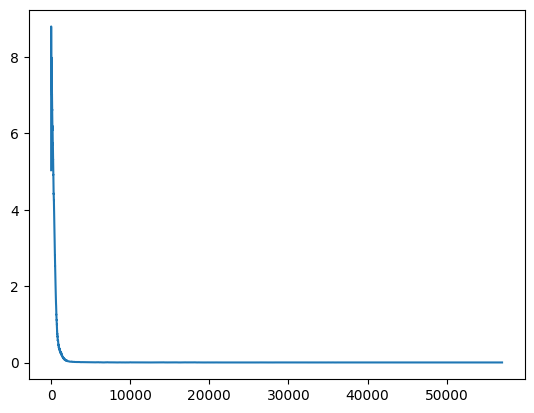

In [55]:
pd.Series(losses).ewm(100).mean().plot();

In [56]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [57]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['la constitución es norma de normas']
['achka iachag pangakunapa iuiaikunata sugllapi suiuchiskami ká']
['nukanchipa achka iachag pangakunapimi makiwa kalpachispa kawachiskata rigsisunchi']


In [58]:
!ls -alsh $MODEL_SAVE_PATH

total 5.2G
4.0K drwxrwxr-x  2 americasnlp americasnlp 4.0K Mar 10 11:22 .
4.0K drwxr-xr-x 12 americasnlp americasnlp 4.0K Mar 10 10:59 ..
 28K -rw-rw-r--  1 americasnlp americasnlp  28K Mar 10 11:04 all_texts_file.csv
4.0K -rw-rw-r--  1 americasnlp americasnlp  857 Mar 11 03:03 config.json
4.0K -rw-rw-r--  1 americasnlp americasnlp  184 Mar 11 03:03 generation_config.json
5.2G -rw-rw-r--  1 americasnlp americasnlp 5.2G Mar 11 03:03 pytorch_model.bin
4.8M -rw-rw-r--  1 americasnlp americasnlp 4.8M Mar 11 03:03 sentencepiece.bpe.model
4.0K -rw-rw-r--  1 americasnlp americasnlp 3.5K Mar 11 03:03 special_tokens_map.json
252K -rw-rw-r--  1 americasnlp americasnlp 249K Mar 10 11:04 spm_16k.model
 20K -rw-rw-r--  1 americasnlp americasnlp  18K Mar 10 11:04 spm_16k.vocab
4.8M -rw-rw-r--  1 americasnlp americasnlp 4.8M Mar 10 11:04 spm_nllb_268k.model
4.0K -rw-rw-r--  1 americasnlp americasnlp  570 Mar 11 03:03 tokenizer_config.json


<h1 id="7.-Using-the-model">7. Testing the model</h1>

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [60]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [63]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_SAVE_PATH).cuda(CUDA_CORE)
tokenizer = NllbTokenizer.from_pretrained(MODEL_SAVE_PATH)
fix_tokenizer(tokenizer, new_lang="quechua_Latn")
fix_tokenizer(tokenizer)
# print(tokenizer.convert_ids_to_tokens([262576 + len(added_vocab) + 1, 262576 + len(added_vocab) + 2, 262576 + len(added_vocab) + 3])) # ['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>']
print(tokenizer.convert_tokens_to_ids([LANGUAGE_TARGET_LABEL, '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[263139, 263139, 263140]


In [64]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [65]:
t = "las canciones de amor me gustan mucho"
print(translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL))

['iurakunapa makiwa kalpachispa kuanakuspa, tukuikunami nukanchipa atun llagtapi kaugsag, nukanchipa atun kangapa; chimi chasallata nukanchitapas allilla iuiarispa maskangakuna']


In [66]:
translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['iurakunapa makiwa kalpachispa kuanakuspa, rinri kaugchuikunti tiaskata mana kungaringapa']

In [67]:
t = "kuyakuyllawan takitam anchata kuyani"
print(translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL))

['agradezco a todas las autoridades indígenas, líderes y maestros bilingues quienes, en una u otra forma contribuyeron para que esta obra salga adelante']


In [68]:
translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['me agradezco a todas las autoridades indígenas, líderes y maestros bilingues quienes, en una u otra forma contribuyeron para que esta obra salga adelante']

In [69]:
def batched_translate(texts, batch_size=8, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [70]:
# df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_TARGET_LABEL"], src_lang=LANGUAGE_TARGET_LABEL, tgt_lang=LANGUAGE_ORIGIN_LABEL)
# df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_ORIGIN_LABEL"], src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL)

In [71]:
df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = [translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_TARGET_LABEL])]
df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = [translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_ORIGIN_LABEL])]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [72]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [73]:
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))

BLEU = 1.71 15.7/2.4/0.6/0.4 (BP = 1.000 ratio = 1.171 hyp_len = 567 ref_len = 484)
chrF2++ = 18.40
BLEU = 1.10 12.9/2.3/0.4/0.1 (BP = 1.000 ratio = 1.527 hyp_len = 504 ref_len = 330)
chrF2++ = 29.30


In [74]:
pd.options.display.max_colwidth = 100

In [75]:
df_test.sample(10, random_state=42)[[LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_translated', LANGUAGE_FILE_ORIGIN_LABEL + '_translated']]

,ing,esp,ing_translated,esp_translated
96,kulumbiamanda achka iachag pangakuna iapa ministiskata iuiachidiru,artículos relativos a los principios fundamentales del estado,nukanchipa suma iuiarispa mirachii,"agradecimiento profundo a mi familia, quienes siempre me apoyaron, sacrificando sus vacaciones y..."
86,"kaikunata nukanchipa simima ialichingapa sug iacha sug iachatami chaiarka tapuchispa, tapuchispa...",las limitaciones en cuanto al dinero y en cuanto a lingüistas indígenas disponibles nos impidier...,"ña sutipaika, sug sapalla runa, mana achka iachag pangata nukanchipa simipi ialichispa churaspa,...",cada dos meses se reunían con nosotros en bogotá donde examinábamos las dificultades entre todos...
9,nukanchipa simipi ialichigta aidagkunapasmi nukanchipa rimaita askuarinti allilla rimagmi kankuna,antonio cuatindioy gobernador del cabildo inga de san andrés,"bogotámanda kaiawai kallariuraka, pirmisukuna mañaspami iacharkani ringa",692 cúcuta gobernador del cabildo inga de santiago
150,"pusag chunga sugta, pusag chunga kanchis, pusag chunga pusag hordator (86,87,88) achka iachag ku...","algunos de los derechos son considerados fundamentales como el derecho a la vida, la libertad pe...","kai suma iuiaspa kaugsai mana ñi pipas wañuchii u wañuchichii mana pudingapa kanchu, mana kichun...",son nacionales colombianos muy prestos a colaborar asistiendo a los seminarios de traducción efe...
82,ña chasakari sutipami iachi nukanchipa rimaima ialichiskasina,creemos que se allanó el camino para traducir los otros cuando surja la necesidad,"chasa mana chasa kuawagpikunaka, maikan kai achka iachag pangata nukanchipa simima ialichingapa,...","por eso, este texto no se conformó con convertir una palabra hispánica en otra indígena, sino qu..."
93,imasa nukanchita iaia sakiskasina,digitalizado por sistema de bibliotecas-universidad de los andes,"kamkikinkunapagmandakunami rurarkakuna antiwama iachaikunatami iachaikurkanchi, chikunawa tukuik...",la erradicación del analfabetismo y la educación de personas con limitaciones físicas o mentales...
135,iukanganapasmi chi suma iuiakuna achka iachag pangakuna i achka iachag pangakunapa wawapi imasa ...,cualquier persona puede exigir a la autoridad competente su cumplimiento y la sanción de los inf...,"nukanchipa atun llagtapi awanigmanda kawadurkunata katiraigkuna, nukanchipa atun llagtapi kaugsa...",también habrá un consejo nacional de planeación integrado por representantes de las entidades te...
104,nukanchipa atun llagta kulumbia tukuikunamanda sumaglla kaugsangapa,"colombia es un estado social de derecho, organizado en forma de república unitaria, descentraliz...","atun llagta tukuikunatami iuka rigsichinga, tukuikunapa iuiai i kaugsaita, sug rigcha kaugsaikun...",el estado reconoce la igualdad y dignidad de todas las que conviven en el país
181,"iurakuna i nukanchipa runakunapas, sug llagtapi kaugsagriskakunapasmi pudinkuna awanigmanda kawa...",los ciudadanos colombianos que se encuentren o residan en el exterior podrán sufragar en las ele...,"kai llagtapi kausag pangakunata nukanchipa awanigmanda kawadurkunata katiraigkuna, nukanchipa at...",la constitución colombiana nos dice cuáles son nuestros derechos y la manera de protegerlos y ex...
73,"chikunata rigsigkuna sutikankunami: mamos, payés, chamanes, taitakuna i achalakuna u nukanchita ...","este trabajo y una constante discusión sobre las, muy diversas, tradiciones indígenas de colombi...","chi achka iachag pangakunapi, nukanchipa simipimi iukanchiirkakuna, nispami askurinti iacha i as...",el estado reconoce los derechos inalienables de la persona y ampara a la familia como institució...
